In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import ssl
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = None

# Load Dataset + Merge

In [3]:
postings = pd.read_csv('postings.csv')
print(postings.shape)
postings.head()

(123849, 31)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,30.0,Full-time,NaN,1.712858e+12,NaN,https://www.linkedin.com/jobs/view/1829192/?tr...,NaN,ComplexOnsiteApply,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,60000.0,Full-time,NaN,1.713452e+12,NaN,https://www.linkedin.com/jobs/view/35982263/?t...,NaN,ComplexOnsiteApply,1.716044e+12,NaN,NaN,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [4]:
for col in postings.columns:
    na_vals = round(postings[col].isnull().sum()/postings.shape[0], 2)
    print(col, na_vals)

job_id 0.0
company_name 0.01
title 0.0
description 0.0
max_salary 0.76
pay_period 0.71
location 0.0
company_id 0.01
views 0.01
med_salary 0.95
min_salary 0.76
formatted_work_type 0.0
applies 0.81
original_listed_time 0.0
remote_allowed 0.88
job_posting_url 0.0
application_url 0.3
application_type 0.0
expiry 0.0
closed_time 0.99
formatted_experience_level 0.24
skills_desc 0.98
listed_time 0.0
posting_domain 0.32
sponsored 0.0
work_type 0.0
currency 0.71
compensation_type 0.71
normalized_salary 0.71
zip_code 0.17
fips 0.22


In [5]:
postings.dropna(subset=['normalized_salary'], inplace=True)

In [6]:
postings['job_id'].nunique()

36073

In [7]:
industries = pd.read_csv('companies/company_industries.csv')
industries.head()

,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


In [8]:
postings = postings.merge(industries, on='company_id')
print(postings.shape)
postings.head()

(35580, 32)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,industry
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,Real Estate
1,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,Restaurants
2,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,Law Practice
3,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,14.0,Internship,4.0,1.713456e+12,NaN,https://www.linkedin.com/jobs/view/91700727/?t...,NaN,ComplexOnsiteApply,1.716048e+12,NaN,NaN,NaN,1.713456e+12,NaN,0,INTERNSHIP,USD,BASE_SALARY,35360.0,27601.0,37183.0,Non-profit Organizations
4,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,60000.0,Contract,1.0,1.712861e+12,1.0,https://www.linkedin.com/jobs/view/103254301/?...,NaN,SimpleOnsiteApply,1.715453e+12,NaN,NaN,NaN,1.712861e+12,NaN,0,CONTRACT,USD,BASE_SALARY,180000.0,NaN,NaN,Design Services


In [9]:
skills = pd.read_csv('jobs/job_skills.csv')
skills.head()

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


In [10]:
skills_mapping = pd.read_csv('mappings/skills.csv').rename(columns={'skill_name': 'field'})
skills_mapping.head()

,skill_abr,field
0,ART,Art/Creative
1,DSGN,Design
2,ADVR,Advertising
3,PRDM,Product Management
4,DIST,Distribution


In [11]:
skills = skills.merge(skills_mapping, on='skill_abr').drop(columns='skill_abr')

In [12]:
grouped_skills = pd.DataFrame(skills.groupby('job_id')['field'].apply(lambda x: ', '.join(x))).reset_index()
grouped_skills

,job_id,field
0,921716,"Marketing, Sales"
1,1218575,Health Care Provider
2,1829192,Health Care Provider
3,2264355,"Design, Art/Creative, Information Technology"
4,10998357,"Management, Manufacturing"
...,...,...
126802,3906267117,"Legal, Business Development"
126803,3906267126,"Engineering, Information Technology"
126804,3906267131,"Sales, Business Development"
126805,3906267195,"Business Development, Sales"


In [13]:
postings = postings.merge(grouped_skills, on='job_id')
print(postings.shape)
postings.head()

(35116, 33)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,min_salary,formatted_work_type,applies,original_listed_time,remote_allowed,job_posting_url,application_url,application_type,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips,industry,field
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,17.0,Full-time,2.0,1.713398e+12,NaN,https://www.linkedin.com/jobs/view/921716/?trk...,NaN,ComplexOnsiteApply,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,Real Estate,"Marketing, Sales"
1,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,45000.0,Full-time,NaN,1.713278e+12,NaN,https://www.linkedin.com/jobs/view/10998357/?t...,NaN,ComplexOnsiteApply,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,Restaurants,"Management, Manufacturing"
2,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,140000.0,Full-time,NaN,1.712896e+12,NaN,https://www.linkedin.com/jobs/view/23221523/?t...,NaN,ComplexOnsiteApply,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,Law Practice,Other
3,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,14.0,Internship,4.0,1.713456e+12,NaN,https://www.linkedin.com/jobs/view/91700727/?t...,NaN,ComplexOnsiteApply,1.716048e+12,NaN,NaN,NaN,1.713456e+12,NaN,0,INTERNSHIP,USD,BASE_SALARY,35360.0,27601.0,37183.0,Non-profit Organizations,Project Management
4,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,60000.0,Contract,1.0,1.712861e+12,1.0,https://www.linkedin.com/jobs/view/103254301/?...,NaN,SimpleOnsiteApply,1.715453e+12,NaN,NaN,NaN,1.712861e+12,NaN,0,CONTRACT,USD,BASE_SALARY,180000.0,NaN,NaN,Design Services,"Design, Art/Creative, Information Technology"


# Data Cleaning

In [14]:
postings_cleaned = postings.copy()

In [15]:
postings_cleaned.drop(columns = ['max_salary', 'pay_period', 'company_id',
                         'med_salary', 'original_listed_time', 'job_posting_url', 
                         'application_url', 'expiry', 'min_salary', 'closed_time',
                         'listed_time', 'work_type', 'currency', 'fips', 'sponsored',
                         'remote_allowed', 'title', 'skills_desc', 'applies', 'compensation_type'
                         ], inplace=True)

In [16]:
postings_cleaned.rename(columns = {
    'company_name': "company",
    'formatted_work_type': "work_type", 
    'formatted_experience_level': 'experience',
    'compensation_type': 'compensation',
    'normalized_salary': 'average_salary'
}, inplace=True)

In [17]:
postings_cleaned['work_type'] = postings_cleaned['work_type'].str.replace('-', ' ')
postings_cleaned['work_type'] = postings_cleaned['work_type'].str.title()

In [18]:
postings_cleaned['application_type'] = postings_cleaned['application_type'].str.replace(r'(?!^)([A-Z])', r' \1', regex=True)

In [19]:
postings_cleaned

,job_id,company,description,location,views,work_type,application_type,experience,posting_domain,average_salary,zip_code,industry,field
0,921716,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,"Princeton, NJ",20.0,Full Time,Complex Onsite Apply,NaN,NaN,38480.0,8540.0,Real Estate,"Marketing, Sales"
1,10998357,The National Exemplar,The National Exemplar is accepting application...,"Cincinnati, OH",8.0,Full Time,Complex Onsite Apply,NaN,NaN,55000.0,45202.0,Restaurants,"Management, Manufacturing"
2,23221523,"Abrams Fensterman, LLP",Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",16.0,Full Time,Complex Onsite Apply,NaN,NaN,157500.0,11040.0,Law Practice,Other
3,91700727,Downtown Raleigh Alliance,Job summary:The Economic Development & Plannin...,"Raleigh, NC",9.0,Internship,Complex Onsite Apply,NaN,NaN,35360.0,27601.0,Non-profit Organizations,Project Management
4,103254301,Raw Cereal,Company DescriptionRaw Cereal is a creative de...,United States,7.0,Contract,Simple Onsite Apply,NaN,NaN,180000.0,NaN,Design Services,"Design, Art/Creative, Information Technology"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35111,3906265414,"TalentBurst, an Inc 5000 company","Position: Clinical Contracts Analyst, Req#: 63...","Irvine, CA",1.0,Contract,Complex Onsite Apply,Mid-Senior level,NaN,83200.0,92602.0,Staffing and Recruiting,"Legal, Finance, Writing/Editing"
35112,3906266165,Athena Recruiting,This role handles all the onsite catering and ...,Greater Indianapolis,3.0,Part Time,Complex Onsite Apply,Associate,NaN,57500.0,NaN,Staffing and Recruiting,Administrative
35113,3906266272,"TalentBurst, an Inc 5000 company",Position: Quality Engineer I (Complaint Invest...,"Irvine, CA",1.0,Contract,Complex Onsite Apply,Mid-Senior level,NaN,83200.0,92602.0,Staffing and Recruiting,Engineering
35114,3906267117,Lozano Smith,Our Walnut Creek office is currently seeking a...,"Walnut Creek, CA",1.0,Full Time,Complex Onsite Apply,Mid-Senior level,NaN,157500.0,94595.0,Law Practice,"Legal, Business Development"


In [20]:
for col in postings_cleaned.columns:
    na_count = round(postings_cleaned[col].isnull().sum()/postings_cleaned.shape[0], 4)
    print(col, na_count)

job_id 0.0
company 0.0
description 0.0
location 0.0
views 0.013
work_type 0.0
application_type 0.0
experience 0.2055
posting_domain 0.3969
average_salary 0.0
zip_code 0.188
industry 0.0
field 0.0


In [21]:
postings_cleaned['views'].fillna(postings_cleaned['views'].median(), inplace=True)
postings_cleaned['experience'].fillna('Missing', inplace = True)
postings_cleaned.drop(columns = ['posting_domain'], inplace = True)
postings_cleaned['zip_code'].fillna(0, inplace = True)

In [22]:
for col in postings_cleaned.columns:
    na_count = round(postings_cleaned[col].isnull().sum()/postings_cleaned.shape[0], 4)
    print(col, na_count)

job_id 0.0
company 0.0
description 0.0
location 0.0
views 0.0
work_type 0.0
application_type 0.0
experience 0.0
average_salary 0.0
zip_code 0.0
industry 0.0
field 0.0


In [23]:
Q1 = postings_cleaned['average_salary'].quantile(0.25)
Q3 = postings_cleaned['average_salary'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

postings_cleaned = postings_cleaned[(postings_cleaned['average_salary'] >= lower_bound) & (postings_cleaned['average_salary'] <= upper_bound)]
print(postings_cleaned.shape)

(34183, 12)


In [24]:
postings_cleaned['state'] = postings_cleaned['location'].apply(lambda x: x[-2:].upper() if ',' in x else 'Other')

postings_cleaned['state'].fillna('Other', inplace=True)

postings_cleaned['state'] = postings_cleaned['state'].replace({'ES': 'Other', 'EA': 'Other', 'DC': 'Other'})

# Data Processing

In [25]:
postings_processed = postings_cleaned.copy()
postings_processed.drop(columns = ['job_id', 'location'])

,company,description,views,work_type,application_type,experience,average_salary,zip_code,industry,field,state
0,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,20.0,Full Time,Complex Onsite Apply,Missing,38480.0,8540.0,Real Estate,"Marketing, Sales",NJ
1,The National Exemplar,The National Exemplar is accepting application...,8.0,Full Time,Complex Onsite Apply,Missing,55000.0,45202.0,Restaurants,"Management, Manufacturing",OH
2,"Abrams Fensterman, LLP",Senior Associate Attorney - Elder Law / Trusts...,16.0,Full Time,Complex Onsite Apply,Missing,157500.0,11040.0,Law Practice,Other,NY
3,Downtown Raleigh Alliance,Job summary:The Economic Development & Plannin...,9.0,Internship,Complex Onsite Apply,Missing,35360.0,27601.0,Non-profit Organizations,Project Management,NC
4,Raw Cereal,Company DescriptionRaw Cereal is a creative de...,7.0,Contract,Simple Onsite Apply,Missing,180000.0,0.0,Design Services,"Design, Art/Creative, Information Technology",Other
...,...,...,...,...,...,...,...,...,...,...,...
35111,"TalentBurst, an Inc 5000 company","Position: Clinical Contracts Analyst, Req#: 63...",1.0,Contract,Complex Onsite Apply,Mid-Senior level,83200.0,92602.0,Staffing and Recruiting,"Legal, Finance, Writing/Editing",CA
35112,Athena Recruiting,This role handles all the onsite catering and ...,3.0,Part Time,Complex Onsite Apply,Associate,57500.0,0.0,Staffing and Recruiting,Administrative,Other
35113,"TalentBurst, an Inc 5000 company",Position: Quality Engineer I (Complaint Invest...,1.0,Contract,Complex Onsite Apply,Mid-Senior level,83200.0,92602.0,Staffing and Recruiting,Engineering,CA
35114,Lozano Smith,Our Walnut Creek office is currently seeking a...,1.0,Full Time,Complex Onsite Apply,Mid-Senior level,157500.0,94595.0,Law Practice,"Legal, Business Development",CA


#### Low Cardinality Columns

In [26]:
one_hot_cols = ['work_type', 'application_type', 'experience', 'state']
postings_processed = pd.get_dummies(postings_processed, columns=one_hot_cols, drop_first=True)

#### High Cardinality Columns

In [27]:
high_card_cols = ['company', 'industry']

for col in high_card_cols:
    freq_map = postings_processed[col].value_counts()
    postings_processed[col + '_freq'] = postings_processed[col].map(freq_map)
    postings_processed.drop(col, axis=1, inplace=True)

#### Multi-Label Columns

In [28]:
def split_fields(x):
    if not isinstance(x, str):
        return []
    return [field.strip() for field in x.split(',')]

postings_processed['field_list'] = postings_processed['field'].apply(split_fields)

mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(postings_processed['field_list'])

encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=postings_processed.index)

postings_processed = pd.concat([postings_processed, encoded_df], axis=1)

postings_processed.drop(['field', 'field_list'], axis=1, inplace=True)

#### TFID Vectorization

In [55]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # 1. Lowercase the text
    text = text.lower()
    # 2. Remove punctuation and special characters (keeping only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 3. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # 4. Tokenize the text
    tokens = text.split()
    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # 6. Lemmatize each token
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin tokens into a single string
    return " ".join(tokens)

# Apply cleaning to your description column
postings_processed['description_clean'] = postings_processed['description'].fillna("").apply(clean_text)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/danielzhu/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/Users/danielzhu/Downloads/DSC148/final_project/nltk_data'
**********************************************************************


In [ ]:
postings_processed

,job_id,description,location,views,average_salary,zip_code,work_type_Full Time,work_type_Internship,work_type_Other,work_type_Part Time,work_type_Temporary,work_type_Volunteer,application_type_Offsite Apply,application_type_Simple Onsite Apply,application_type_Unknown Apply,experience_Director,experience_Entry level,experience_Executive,experience_Internship,experience_Mid-Senior level,experience_Missing,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_Other,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,company_freq,industry_freq,Accounting/Auditing,Administrative,Advertising,Analyst,Art/Creative,Business Development,Consulting,Customer Service,Design,Distribution,Education,Engineering,Finance,General Business,Health Care Provider,Human Resources,Information Technology,Legal,Management,Manufacturing,Marketing,Other,Product Management,Production,Project Management,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,921716,Job descriptionA leading real estate firm in N...,"Princeton, NJ",20.0,38480.0,8540.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,10998357,The National Exemplar is accepting application...,"Cincinnati, OH",8.0,55000.0,45202.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,23221523,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",16.0,157500.0,11040.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,91700727,Job summary:The Economic Development & Plannin...,"Raleigh, NC",9.0,35360.0,27601.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,573,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,103254301,Company DescriptionRaw Cereal is a creative de...,United States,7.0,180000.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Fa

# Exploratory Data Analysis

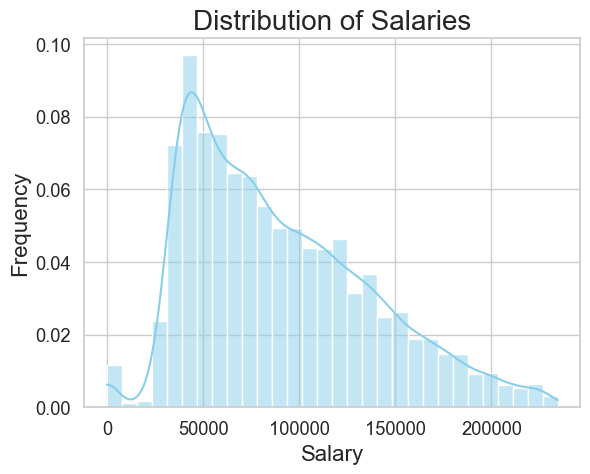

In [30]:
sns.set_theme(style="whitegrid", context="talk")
sns.set_context("notebook", font_scale=1.2)


sns.histplot(data=postings_cleaned, x="average_salary", bins=30, kde=True, color="skyblue", stat='probability')

plt.xlabel("Salary", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Salaries", fontsize=20)
plt.show()

In [31]:
ungrouped_skills = postings_cleaned.merge(skills, on='job_id')

In [32]:
ungrouped_skills

,job_id,company,description,location,views,work_type,application_type,experience,average_salary,zip_code,industry,field_x,state,field_y
0,921716,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,"Princeton, NJ",20.0,Full Time,Complex Onsite Apply,Missing,38480.0,8540.0,Real Estate,"Marketing, Sales",NJ,Marketing
1,921716,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,"Princeton, NJ",20.0,Full Time,Complex Onsite Apply,Missing,38480.0,8540.0,Real Estate,"Marketing, Sales",NJ,Sales
2,10998357,The National Exemplar,The National Exemplar is accepting application...,"Cincinnati, OH",8.0,Full Time,Complex Onsite Apply,Missing,55000.0,45202.0,Restaurants,"Management, Manufacturing",OH,Management
3,10998357,The National Exemplar,The National Exemplar is accepting application...,"Cincinnati, OH",8.0,Full Time,Complex Onsite Apply,Missing,55000.0,45202.0,Restaurants,"Management, Manufacturing",OH,Manufacturing
4,23221523,"Abrams Fensterman, LLP",Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",16.0,Full Time,Complex Onsite Apply,Missing,157500.0,11040.0,Law Practice,Other,NY,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58271,3906266165,Athena Recruiting,This role handles all the onsite catering and ...,Greater Indianapolis,3.0,Part Time,Complex Onsite Apply,Associate,57500.0,0.0,Staffing and Recruiting,Administrative,Other,Administrative
58272,3906266272,"TalentBurst, an Inc 5000 company",Position: Quality Engineer I (Complaint Invest...,"Irvine, CA",1.0,Contract,Complex Onsite Apply,Mid-Senior level,83200.0,92602.0,Staffing and Recruiting,Engineering,CA,Engineering
58273,3906267117,Lozano Smith,Our Walnut Creek office is currently seeking a...,"Walnut Creek, CA",1.0,Full Time,Complex Onsite Apply,Mid-Senior level,157500.0,94595.0,Law Practice,"Legal, Business Development",CA,Legal
58274,3906267117,Lozano Smith,Our Walnut Creek office is currently seeking a...,"Walnut Creek, CA",1.0,Full Time,Complex Onsite Apply,Mid-Senior level,157500.0,94595.0,Law Practice,"Legal, Business Development",CA,Business Development


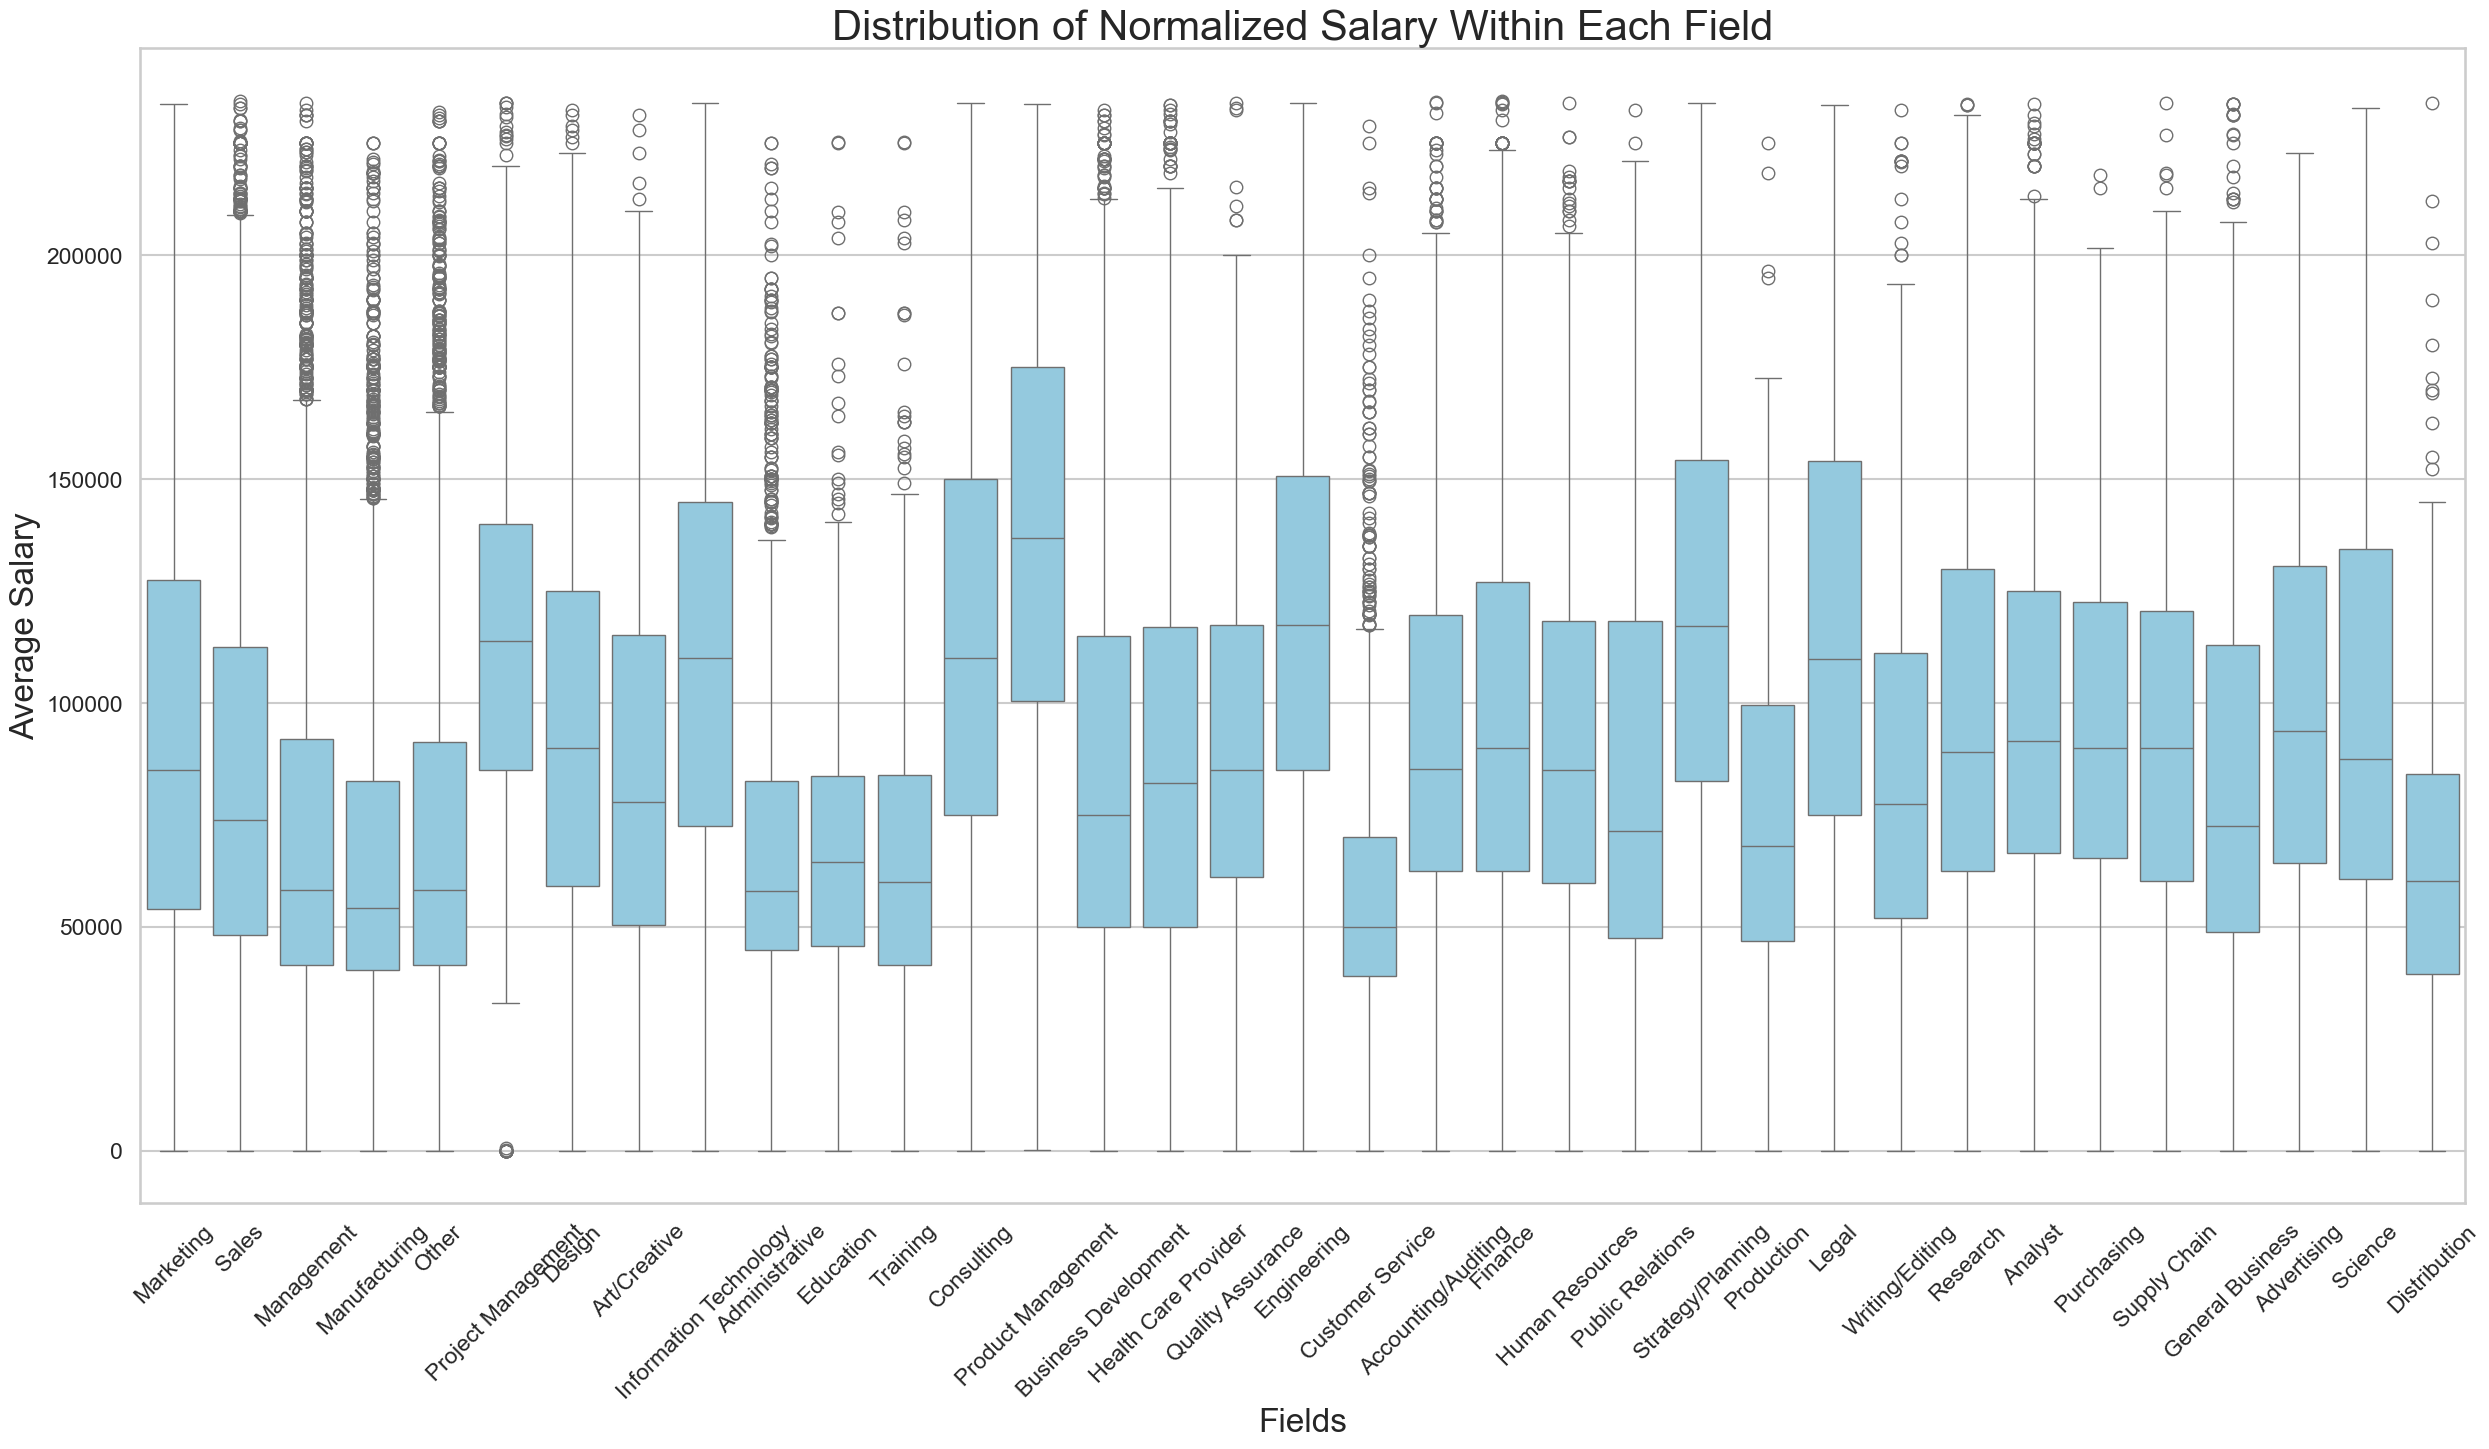

In [33]:
plt.figure(figsize=(30, 15))

sns.set_theme(style="whitegrid", context="talk")
sns.boxplot(x='field_y', y='average_salary', data=ungrouped_skills, color="skyblue")

plt.xticks(rotation=45)

plt.xlabel('Fields', fontsize=24)
plt.ylabel('Average Salary', fontsize=24)
plt.title('Distribution of Normalized Salary Within Each Field', fontsize=30)

plt.show()